In [ ]:
import matplotlib.pyplot as plt 
import os
from pathlib import Path
import torch
import numpy as np

PROJECT_FOLDER = Path(os.getenv("PROJECT_ROOT"))
DATA_FOLDER = PROJECT_FOLDER / "data"
src_path = PROJECT_FOLDER / "src"
tiles_dir = DATA_FOLDER / "tiles"

print("Project folder:", PROJECT_FOLDER)
print("Data folder:", DATA_FOLDER)
print("Tiles folder:", tiles_dir)
print("Source folder:", src_path)


import sys
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

Project folder: D:\Divas\Projects\MSCS\7643\Project\TORTOISE
Data folder: D:\Divas\Projects\MSCS\7643\Project\TORTOISE\data
Tiles folder: D:\Divas\Projects\MSCS\7643\Project\TORTOISE\data\tiles
Source folder: D:\Divas\Projects\MSCS\7643\Project\TORTOISE\src


In [2]:
import importlib

import tortoise.dataset as dataset   
importlib.reload(dataset)            

import tortoise.augmentations as aug
importlib.reload(aug)

<module 'tortoise.augmentations' from 'D:\\Divas\\Projects\\MSCS\\7643\\Project\\TORTOISE\\src\\tortoise\\augmentations.py'>

In [3]:
from tortoise.dataset import *
from tortoise.augmentations import apply_augmentation, AUG_KEYS

In [4]:
tile_key = "00000"
tile_augs = [(tile_key, i) for i in [None] + AUG_KEYS]
print(tile_augs)

[('00000', None), ('00000', 'hflip'), ('00000', 'vflip'), ('00000', 'dflip'), ('00000', 'rot90'), ('00000', 'noise'), ('00000', 'blur'), ('00000', 'iscale')]


In [20]:
def to_display_rgb(tensors_list, channels=(0, 1, 2), rescale=True, aug_names=None, nrows=2, ncols=4):
    """
    Convert a list of image tensors to displayable RGB arrays and plot in subplots grid.
    
    Args:
        tensors_list: List of torch.Tensor, each shape (C, H, W) where C is 3 (RGB) or 13 (MS)
        channels: 3-tuple of int, indices to select from C dimension
                  - For RGB (C=3): ignored, all 3 channels used
                  - For MS (C=13): e.g., (2, 1, 0) for RGB display
        rescale: bool, if True rescale to [0, 1] using 1st/99th percentile
        aug_names: optional list of strings, names for each subplot (e.g., augmentation names)
        nrows: int, number of rows in subplot grid (default 4)
        ncols: int, number of columns in subplot grid (default 2)
    
    Returns:
        fig, axes from plt.subplots with images displayed
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axes = axes.flatten()  # Flatten for easy iteration
    
    n = len(tensors_list)
    
    for idx, tensor in enumerate(tensors_list):
        # Convert to numpy (C, H, W) -> (H, W, C)
        if isinstance(tensor, torch.Tensor):
            img_chw = tensor.cpu().numpy()
        else:
            img_chw = tensor
        
        img_hwc = img_chw.transpose(1, 2, 0)  # (H, W, C)
        
        C = img_hwc.shape[2]
        
        # Select channels
        if C == 3:
            # RGB: use all 3 channels
            selected = img_hwc
        else:
            # MS: extract specified channels
            selected = np.stack([img_hwc[:, :, ch] for ch in channels], axis=-1)
        
        # Rescale for display
        if rescale:
            vmin = np.nanpercentile(selected, 1)
            vmax = np.nanpercentile(selected, 99)
            if vmax > vmin:
                selected = (selected - vmin) / (vmax - vmin)
            selected = np.clip(selected, 0.0, 1.0)
        
        axes[idx].imshow(selected)
        axes[idx].axis("off")
        
        # Add subplot title if aug_names provided
        if aug_names is not None and idx < len(aug_names):
            axes[idx].set_title(aug_names[idx], fontsize=10, pad=5)
    
    # Hide unused subplots
    for idx in range(n, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    return fig, axes


In [9]:
train_ds = TileDataset(
    tiles_dir=tiles_dir,
    tile_ids=tile_augs,
    use_rgb=True,
    use_ms = False,
)
# Example with MS tiles (13 bands) - using NIR, Red, Green channels for display
train_ds_ms = TileDataset(
    tiles_dir=tiles_dir,
    tile_ids=tile_augs,
    use_ms=True,
    use_rgb=False,
)

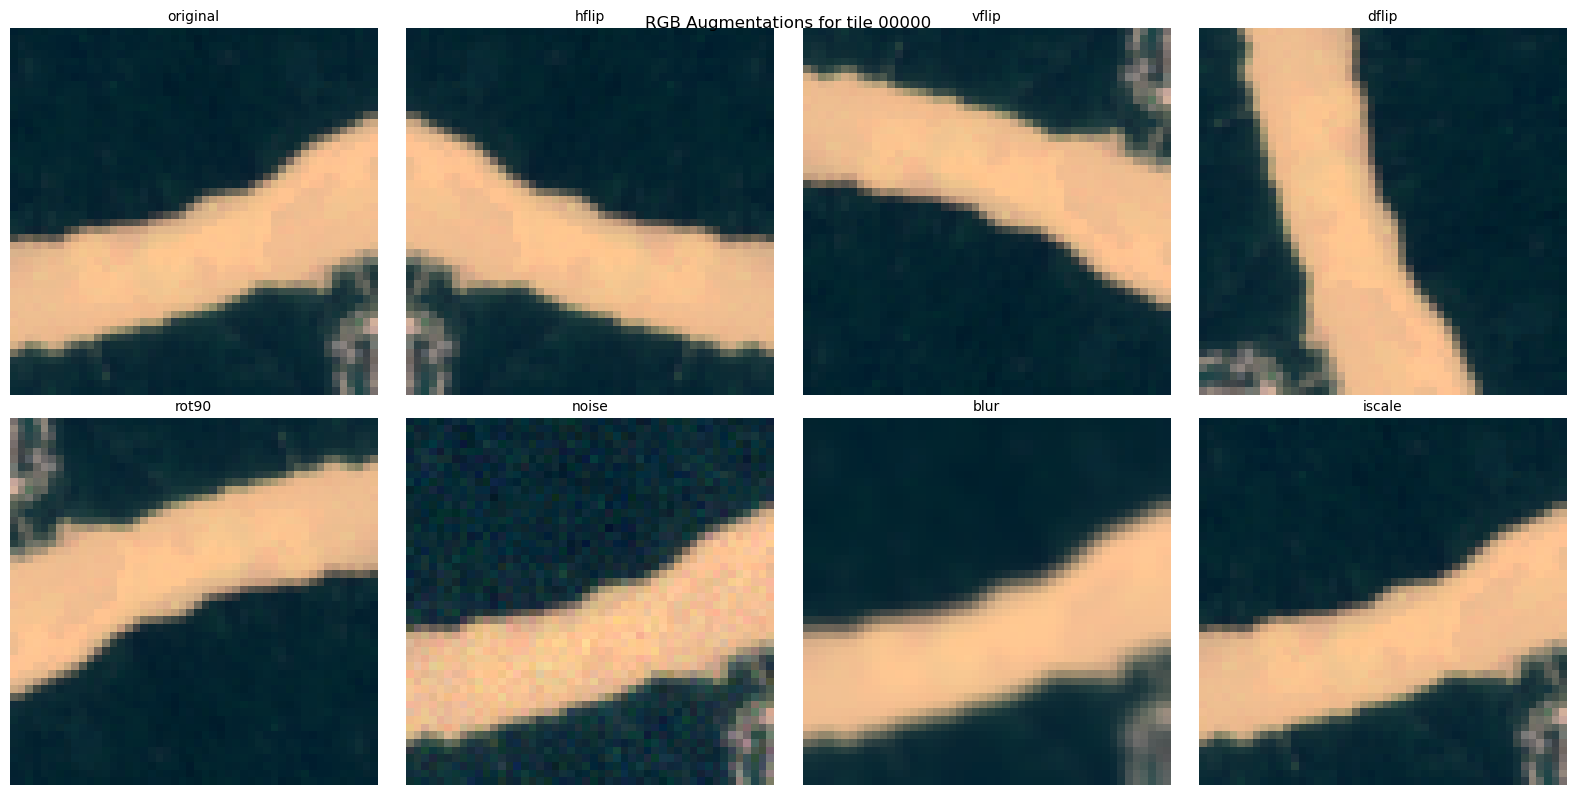

In [21]:
# Display augmented RGB variants in subplots
rgb_tensors = [train_ds[i]['rgb'] for i in range(len(train_ds))]
# Get augmentation names: first is "original", rest are from AUG_KEYS
aug_labels = ["original"] + AUG_KEYS
fig, axes = to_display_rgb(rgb_tensors, rescale=True, aug_names=aug_labels)
plt.suptitle(f"RGB Augmentations for tile {tile_key}", y=0.98)
plt.show()


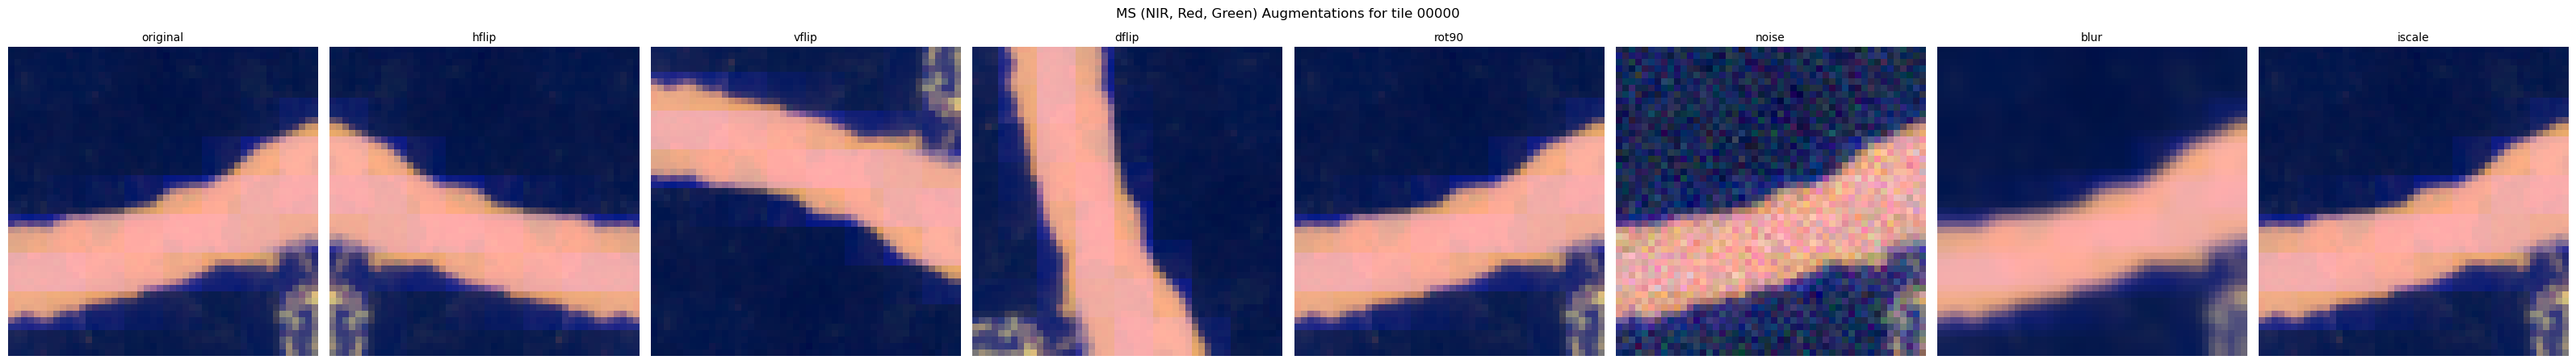

In [15]:
ms_tensors = [train_ds_ms[i]['ms'] for i in range(len(train_ds_ms))]
# Get augmentation names: first is "original", rest are from AUG_KEYS
aug_labels = ["original"] + AUG_KEYS
# NIR=2, Red=1, Green=0 (common RGB-like display)
fig, axes = to_display_rgb(ms_tensors, channels=(2, 1, 0), rescale=True, aug_names=aug_labels)
plt.suptitle(f"MS (NIR, Red, Green) Augmentations for tile {tile_key}", y=0.98)
plt.show()
